In [164]:
from cheetah import Segment, ParticleBeam
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

beam = ParticleBeam.from_twiss(
    beta_x=torch.tensor(9.34),
    alpha_x=torch.tensor(-1.6946),
    emittance_x=torch.tensor(1e-7),
    beta_y=torch.tensor(9.34),
    alpha_y=torch.tensor(-1.6946),
    emittance_y=torch.tensor(1e-7),
    energy=torch.tensor(90e6),
    num_particles=10000,
    total_charge=torch.tensor(1e-9)
)
print(os.getcwd())
segment = Segment.from_lattice_json("../lattices/diag0.json")

#segment.plot_twiss(reconstruction_beam)


/Users/cgarnier/Desktop/CheetahSimEpicsServer/sim/Linac-Simulation-Server/notebooks


In [165]:

import h5py
with h5py.File('../h5/tcav_calibration.h5', 'r') as f:
    print(list(f.keys()))  # Top-level groups/datasets
    data = f['setpoints'][:]

['images', 'screen', 'screen_resolution', 'setpoints']


In [166]:
print(data)

[31.14       32.25111111 33.36222222 34.47333333 35.58444444 36.69555556
 37.80666667 38.91777778 40.02888889 41.14      ]


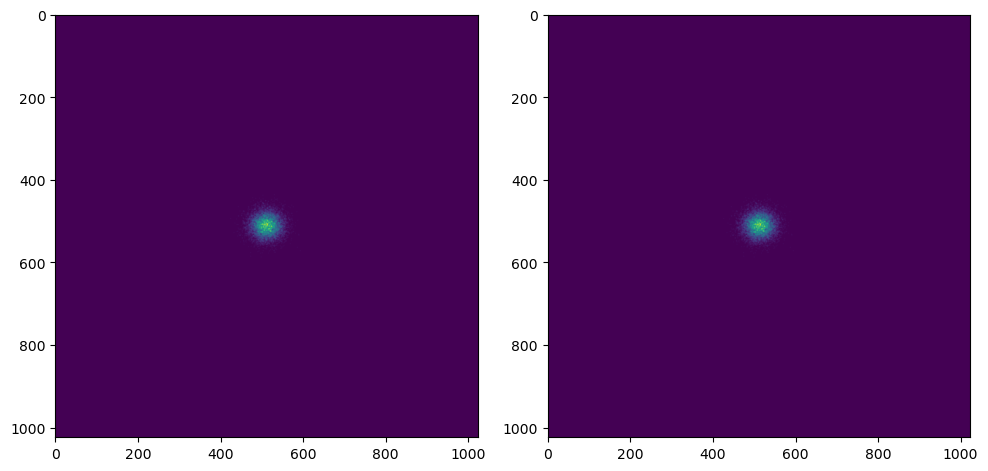

In [ ]:
import matplotlib.pyplot as plt
#print(segment.otrdg02.is_active)

init_beam = segment.otrdg02.reading
#segment.qdg009.k1= torch.tensor(-17.0)
#segment.qdg009.k1= torch.tensor(-11.539229393005371)
segment.tcxdg0.phase= torch.tensor(45)
#print(segment.tcxdg0.voltage)
#segment.tcxdg0.voltage = torch.tensor(3.5e6)
outoging_beam = segment.track(beam)
otr2_data = segment.otrdg02.reading

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(init_beam)
axs[1].imshow(otr2_data)
plt.tight_layout()
plt.show()


#beam = segment.otrdg02.get_read_beam()
#print(beam.sigma_x)

TransverseDeflectingCavity(length=tensor(0.5080), voltage=tensor(350000.), phase=tensor(45), frequency=tensor(2.8560e+09), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='bmadx', name='tcxdg0')


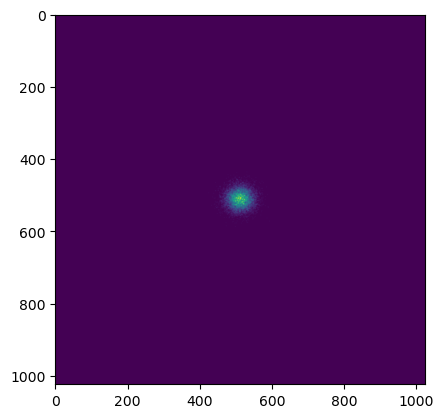

In [168]:
print(segment.tcxdg0)
segment.tcxdg0.phase= torch.tensor(45)
segment.track(beam)
otr2 = segment.otrdg02.reading
plt.imshow(otr2)

ParticleBeam(particles=tensor([[-1.2667e-04,  2.1916e-04, -2.3202e-04,  ...,  3.0545e-06,
         -1.5645e-04,  1.0000e+00],
        [ 2.0755e-04,  7.7087e-04,  4.9151e-05,  ..., -5.6991e-07,
         -4.0401e-04,  1.0000e+00],
        [ 2.1884e-04, -4.4964e-04, -2.2418e-04,  ...,  7.3043e-06,
          3.0836e-04,  1.0000e+00],
        ...,
        [ 2.1656e-04, -6.1331e-05,  1.8165e-04,  ...,  1.6516e-06,
          8.2757e-05,  1.0000e+00],
        [-2.7849e-05,  1.7418e-04, -2.1900e-04,  ..., -4.2261e-06,
         -1.0898e-04,  1.0000e+00],
        [ 1.3659e-04,  9.3829e-04, -4.5338e-04,  ...,  4.6576e-06,
         -5.1556e-04,  1.0000e+00]]), energy=90000000.0, particle_charges=tensor([1.0000e-13, 1.0000e-13, 1.0000e-13,  ..., 1.0000e-13, 1.0000e-13,
        1.0000e-13]), survival_probabilities=tensor([1., 1., 1.,  ..., 1., 1., 1.]), species=Species(name='electron', num_elementary_charges=tensor(-1), mass_eV=tensor(510998.9375)))
tensor(0.0002)
ParticleBeam(particles=tensor([[ 2.9

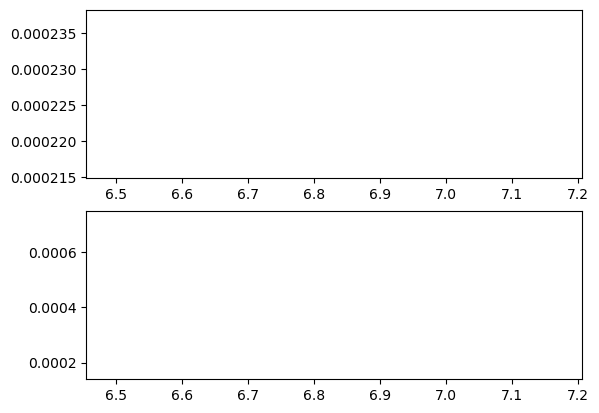

In [171]:
fig,ax = plt.subplots(2,1)

for i, ele in enumerate([segment.otrdg02, segment.otrdg04]):
    beam = ele.get_read_beam()
    print(beam)
    print(beam.sigma_x)
    ax[i].plot(segment.qdg006.k1.detach().cpu().numpy(), beam.sigma_x.detach().cpu().numpy())
    ax[i].plot(segment.qdg006.k1.detach().cpu().numpy(), beam.sigma_y.detach().cpu().numpy())